In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from spectral_metric.estimator import CumulativeGradientEstimator
from spectral_metric.visualize import make_graph

In [3]:
# Lectura de dataset

directorio_dataset = ('../Datasets/CIFAR-10 dos clases')
directorio_dataset = pathlib.Path(directorio_dataset)

imagenes_originales = ('../Datasets/CIFAR-10 dos clases/cat')
imagenes_originales = pathlib.Path(imagenes_originales)

imagenes_corruptas = ('../Datasets/CIFAR-10 dos clases/cat_c_defocus_blur')
imagenes_corruptas = pathlib.Path(imagenes_corruptas)

total_dataset = len(list(directorio_dataset.glob('*/*.png')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_originales = len(list(imagenes_originales.glob('*.png')))  # Cuenta la cantidad de imagenes de la clase original (Aqui busca directamente en la carpeta cat)
total_corruptas = len(list(imagenes_corruptas.glob('*.png')))  # Cuenta la cantidad de imagenes de la clase corrupta (Aqui busca directamente en la carpeta cat_c_defocus_blur)

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes originales: {total_originales}")
print(f"Total imagenes corruptas: {total_corruptas}")

Total imagenes dataset: 10000
Total imagenes originales: 5000
Total imagenes corruptas: 5000


In [4]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = total_dataset

In [5]:
import tensorflow as tf
import pathlib

# Data splitting (entrenamiento y validación)
all_images_in_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_dataset,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.


In [6]:
class_names = all_images_in_dataset.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")

Número de clases: 2
Los nombres de las clases son: ['cat', 'cat_c_defocus_blur']


In [7]:
for images, labels0 in all_images_in_dataset.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(10000, 32, 32, 3)


c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral_metric\visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral_metric\visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


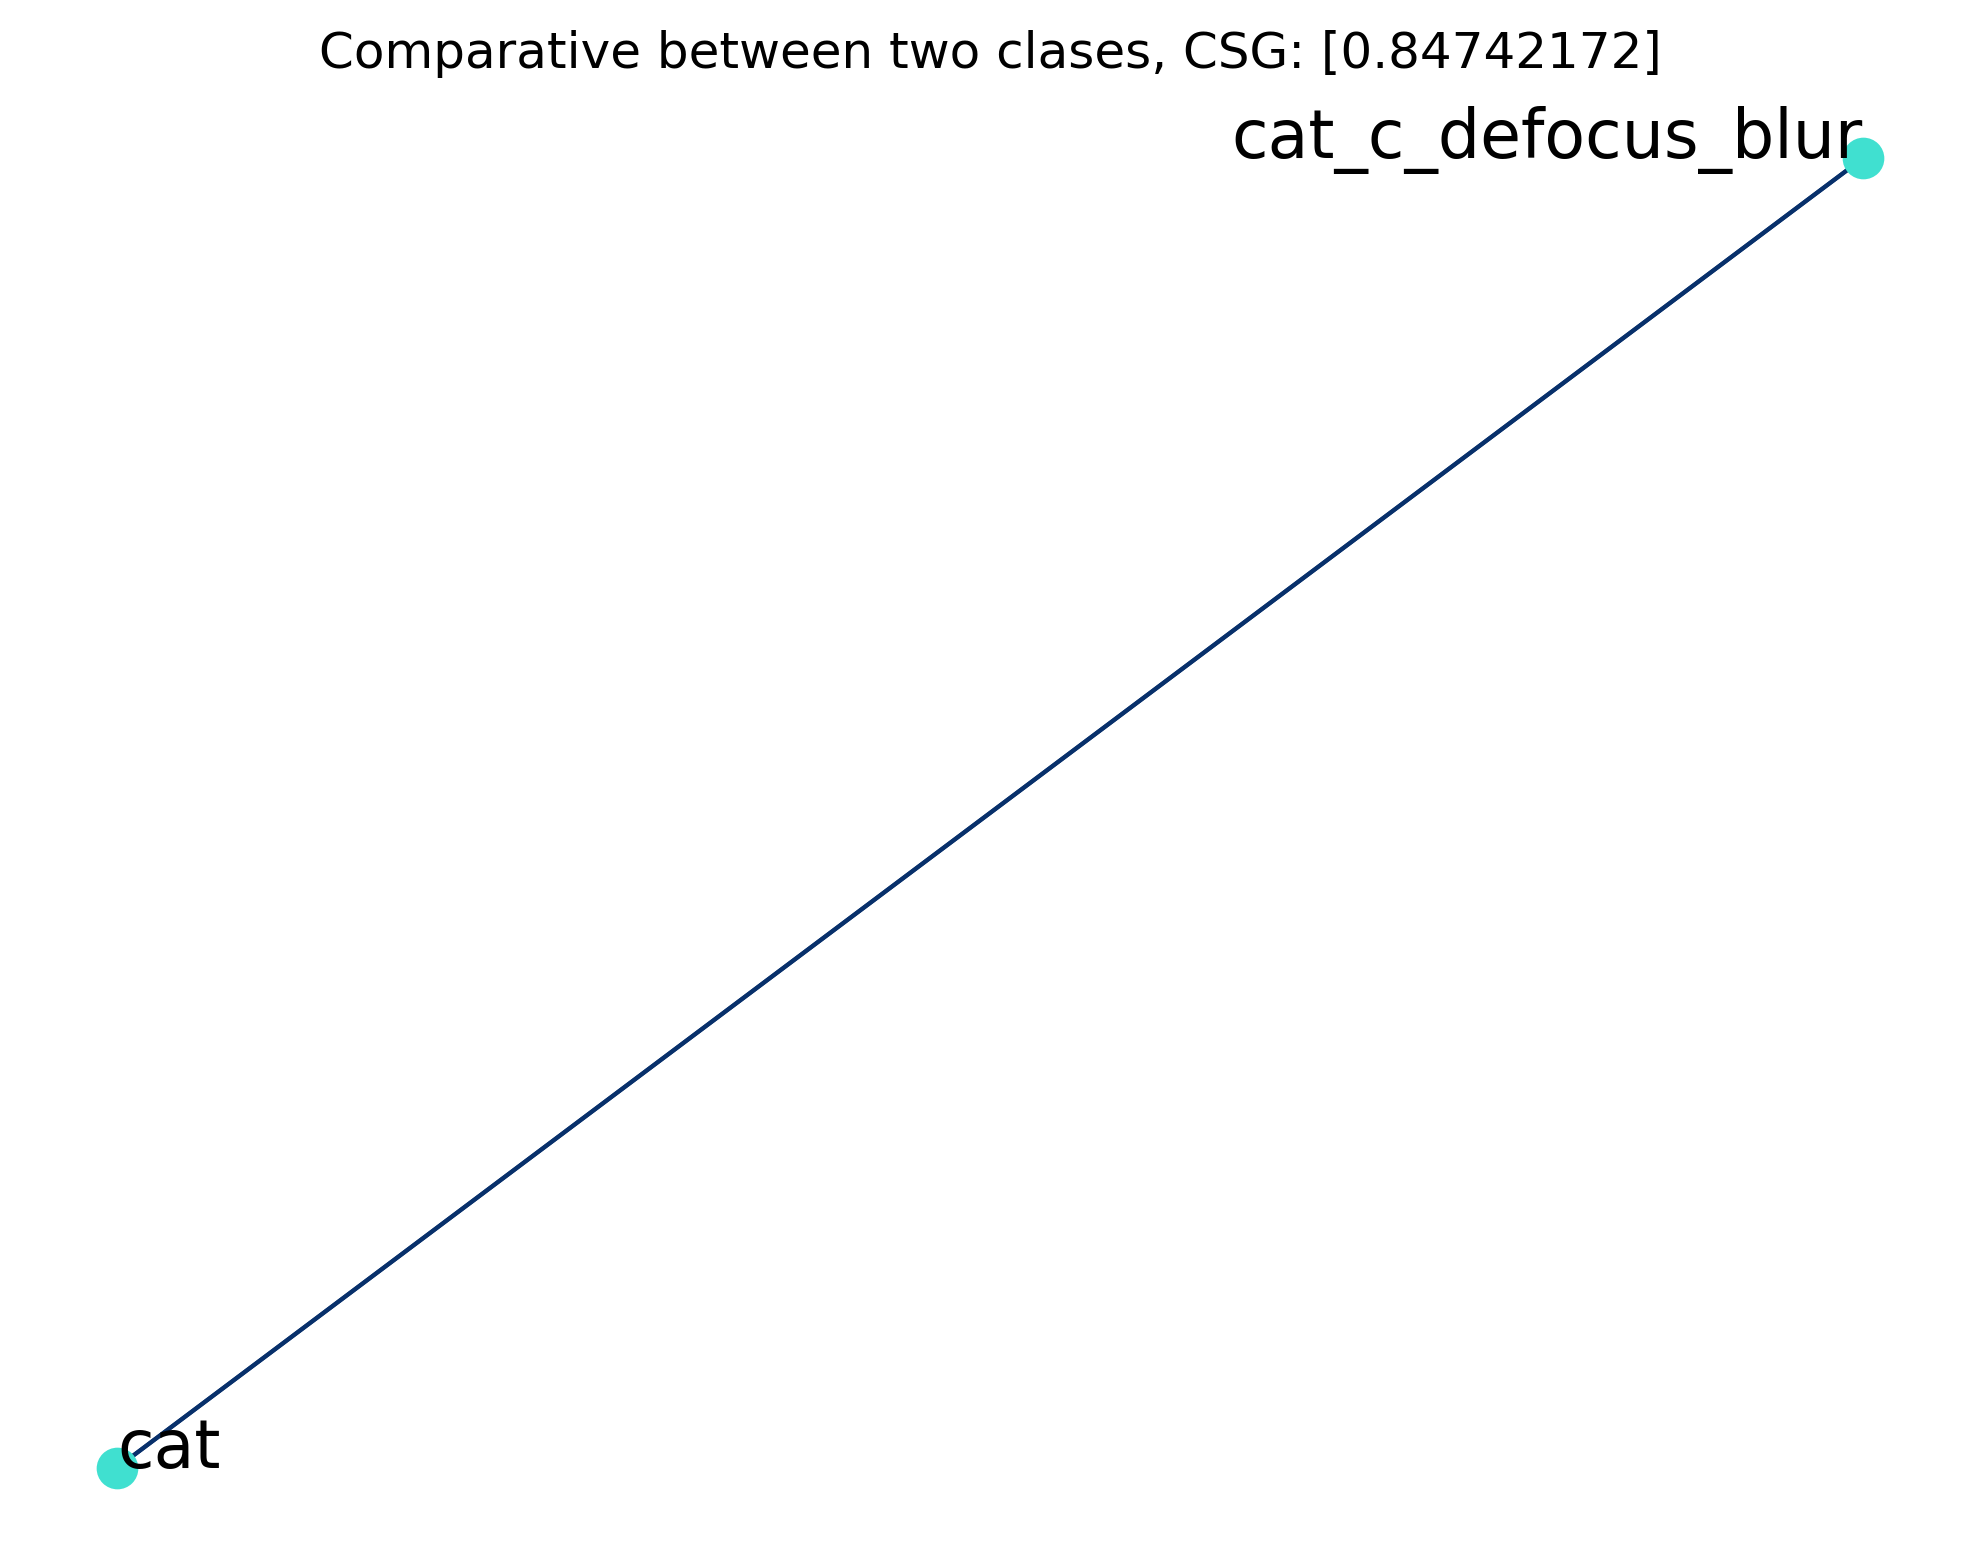

In [8]:
# CIFAR-10 Two classes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)

estimator = CumulativeGradientEstimator(M_sample=1000, k_nearest=10)
estimator.fit(data=fully_dataset, target=fully_labels)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Comparative between two clases, CSG: "+str(csg), classes=class_names)

In [9]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(original,corrupto) for original,corrupto in pairs if original != corrupto]

similitud_de_clases = pairs[0]
original, corrupto = similitud_de_clases  # Pares de clases menos similares

print("Calculo de similitud entre clases")
lst = []
for idx, (original,corrupto) in enumerate(pairs[::2][:1]):
    lst.append({"Clases a comparar" : f"{class_names[original]} <> {class_names[corrupto]}", "Similitud": estimator.W[original,corrupto]})
print(pd.DataFrame(lst))

Calculo de similitud entre clases
           Clases a comparar  Similitud
0  cat <> cat_c_defocus_blur   0.847422


In [10]:
# Obtener las muestras de ambas clases

class_original_samples = class_names.index('cat')
class_corrupto_samples = class_names.index('cat_c_defocus_blur')

original_samples = fully_dataset[fully_labels == class_original_samples] # Esta línea está seleccionando todas las muestras en fully_dataset donde la etiqueta correspondiente en fully_labels es igual a original
corrupto_samples = fully_dataset[fully_labels == class_corrupto_samples] # Esta línea está seleccionando todas las muestras en fully_dataset donde la etiqueta correspondiente en fully_labels es igual a corrupto. Es decir, está seleccionando todas las muestras de la clase corrupta.

In [11]:
from scipy.spatial.distance import cdist
"""
El módulo spatial.distance proporciona funciones para 
calcular distancias entre conjuntos de puntos en espacio 
multidimensional. La función cdist calcula la distancia 
entre cada par de puntos en dos conjuntos de puntos.
"""

# Calcular la matriz de distancias entre las muestras de la clase original y la clase corrupto
dist_original_to_corrupto = cdist(original_samples, corrupto_samples)
# Calcular la matriz de distancias entre las muestras de la clase corrupto y la clase original
dist_corrupto_to_original = cdist(corrupto_samples, original_samples)


# Encontrar el índice de las muestras menos similares (la mayor distancia)
mayor_dist_original_to_corrupto = np.unravel_index(np.argmax(dist_original_to_corrupto), dist_original_to_corrupto.shape)  # devuelve el índice del valor máximo en esta matriz, es decir, la mayor distancia.
# Encontrar el índice de las muestras menos similares (la mayor distancia
mayor_dist_corrupto_to_original = np.unravel_index(np.argmax(dist_corrupto_to_original), dist_corrupto_to_original.shape)  # devuelve el índice del valor máximo en esta matriz, es decir, la mayor distancia.


# Calcular la distancia promedio de cada muestra de la clase original a las muestras de la clase corrupto
avg_dist_original_to_corrupto = dist_original_to_corrupto.mean(axis=1)
# Calcular la distancia promedio de cada muestra de la clase corrupto a las muestras de la clase original
avg_dist_corrupto_to_original = dist_corrupto_to_original.mean(axis=1)


# Encontrar el índice de la muestra de la clase original que tiene la mayor distancia promedio a las muestras de la clase corrupta
mayor_dist_indice_original = np.argmax(avg_dist_original_to_corrupto)
# Encontrar el índice de la muestra de la clase original que tiene la mayor distancia promedio a las muestras de la clase corrupta
mayor_dist_indice_corrupto= np.argmax(avg_dist_corrupto_to_original)

# Obtener los nombres de archivo correspondientes a las muestras
filenames = [f.name for f in directorio_dataset.glob('*/*.png')]
class_original_indices = np.where(fully_labels == class_original_samples)[0]
class_corrupto_indices = np.where(fully_labels == class_corrupto_samples)[0]

muestras_original_to_corrupto_filenames = [filenames[idx] for idx in class_original_indices]
muestras_corrupto_to_original_filenames = [filenames[idx] for idx in class_corrupto_indices]

# Ordenar las distancias promedio en orden descendente y obtener los índices
distancia_promedio_original_ordenada = np.argsort(avg_dist_original_to_corrupto)[::-1]
distancia_promedio_corrupto_ordenada = np.argsort(avg_dist_corrupto_to_original)[::-1]

muestras_original_to_corrupto  = original_samples[distancia_promedio_original_ordenada[:20]]
muestras_original_to_corrupto_filenames = [muestras_original_to_corrupto_filenames[idx] for idx in distancia_promedio_original_ordenada[:20]]


muestras_corrupto_to_original = corrupto_samples[distancia_promedio_corrupto_ordenada[:20]]
muestras_corrupto_to_original_filenames = [muestras_corrupto_to_original_filenames[idx] for idx in distancia_promedio_corrupto_ordenada[:20]]

"""
La función np.unravel_index de numpy convierte un índice 
de arreglo plano en un índice de matriz multidimensional.
Por lo tanto, toda esa linea devuelve una tupla de índices 
que representan la ubicación del valor máximo en la matriz.
"""

# Muestra de la clase original menos similar a las muestras de la clase corrupto
least_similar_original_to_corrupto = original_samples[mayor_dist_original_to_corrupto[0]]
# Muestra de la clase corrupto menos similar a las muestras de la clase original
least_similar_corrupto_to_original = corrupto_samples[mayor_dist_corrupto_to_original[1]]

In [12]:

least_similar_original_to_corrupto_filename = filenames[class_original_indices[mayor_dist_original_to_corrupto[0]]]
least_similar_corrupto_to_original_filename = filenames[class_corrupto_indices[mayor_dist_corrupto_to_original[1]]]

print(f"Clase: {class_names[original]} \n Muestra Menos similar: {least_similar_original_to_corrupto_filename}")
print(f"Clase: {class_names[corrupto]} \n Muestra Menos similar: {least_similar_corrupto_to_original_filename}")

print(class_original_indices.shape)
print(class_corrupto_indices.shape)



Clase: cat 
 Muestra Menos similar: cat_s_001627.png
Clase: cat_c_defocus_blur 
 Muestra Menos similar: 05213.png
(5000,)
(5000,)


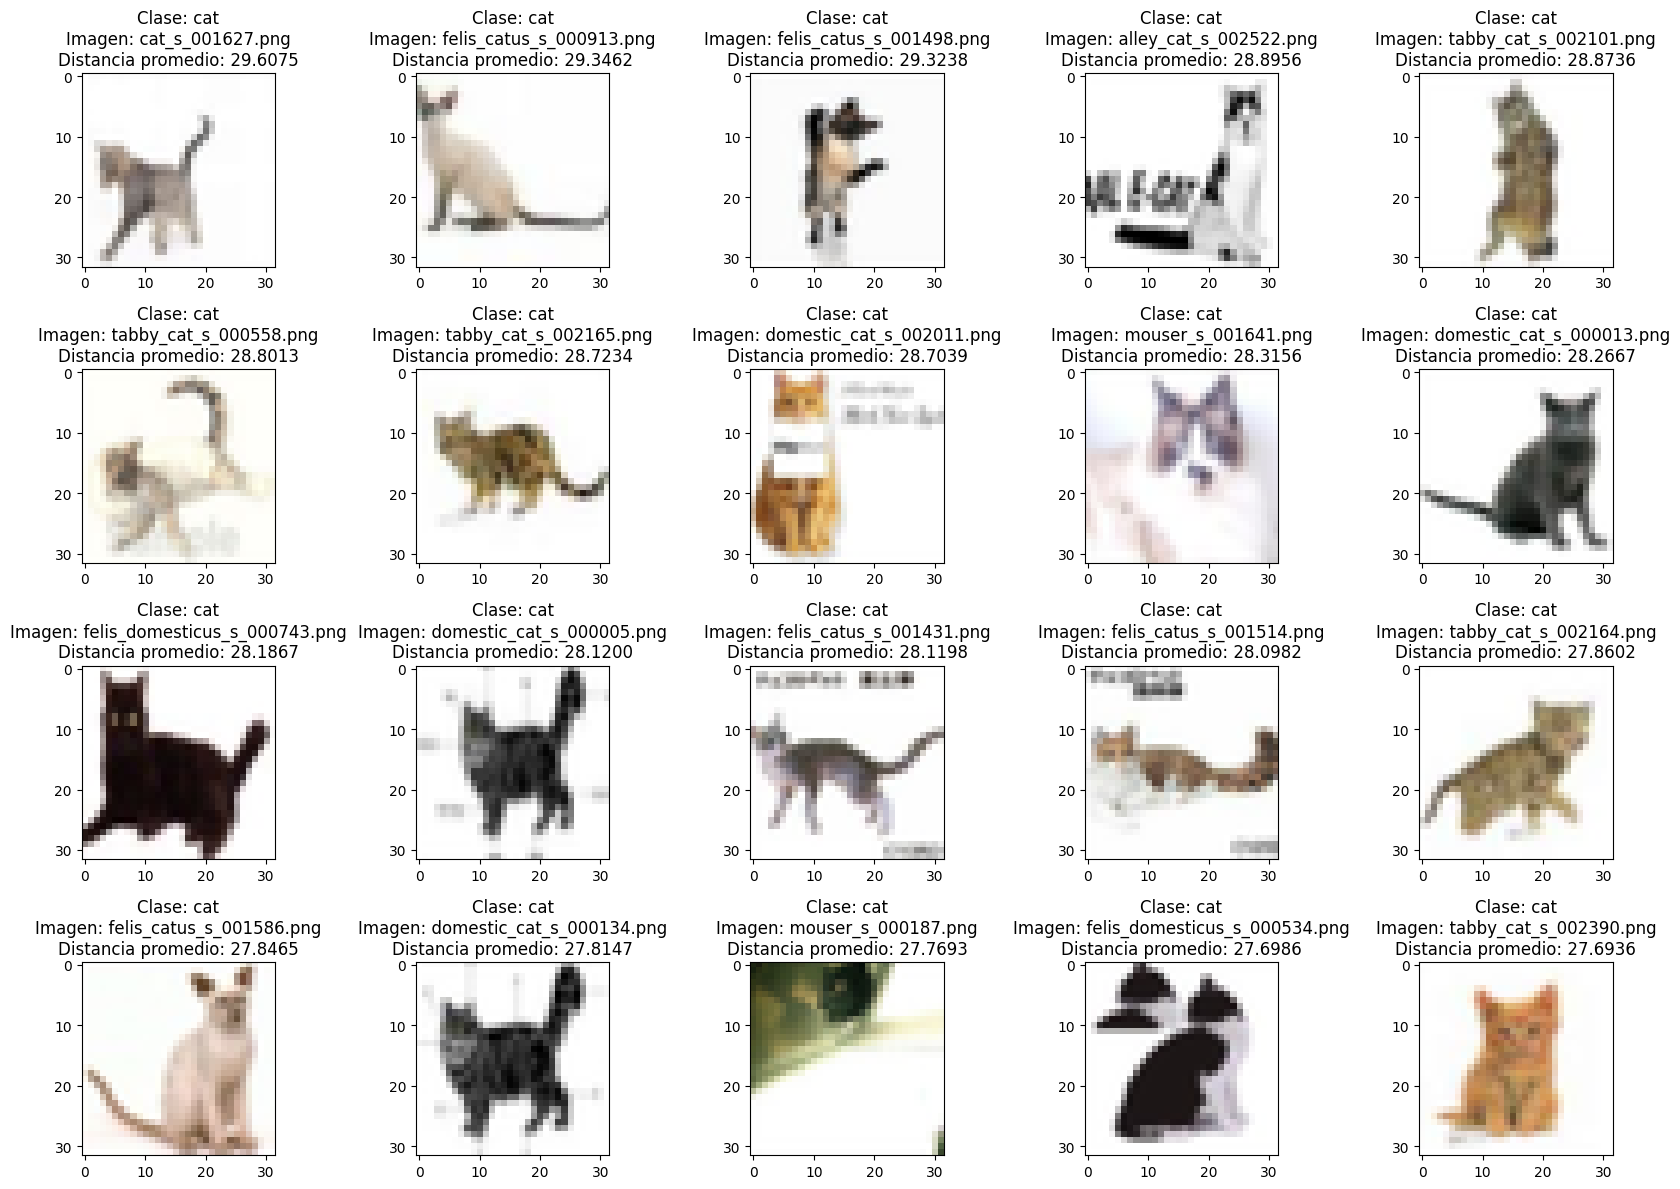

In [13]:
# Visualizar las 10 muestras menos similares
fig, axs = plt.subplots(4, 5, figsize=(17, 12))
for ax, sample, filename, dist in zip(axs.ravel(), muestras_original_to_corrupto, muestras_original_to_corrupto_filenames, avg_dist_original_to_corrupto[distancia_promedio_original_ordenada[:20]]):
    img = sample.reshape(img_height, img_width, 3)
    ax.imshow(img)
    ax.set_title(f'Clase: {class_names[original]}\nImagen: {filename}\nDistancia promedio: {dist:.4f}')
plt.tight_layout()
plt.show()

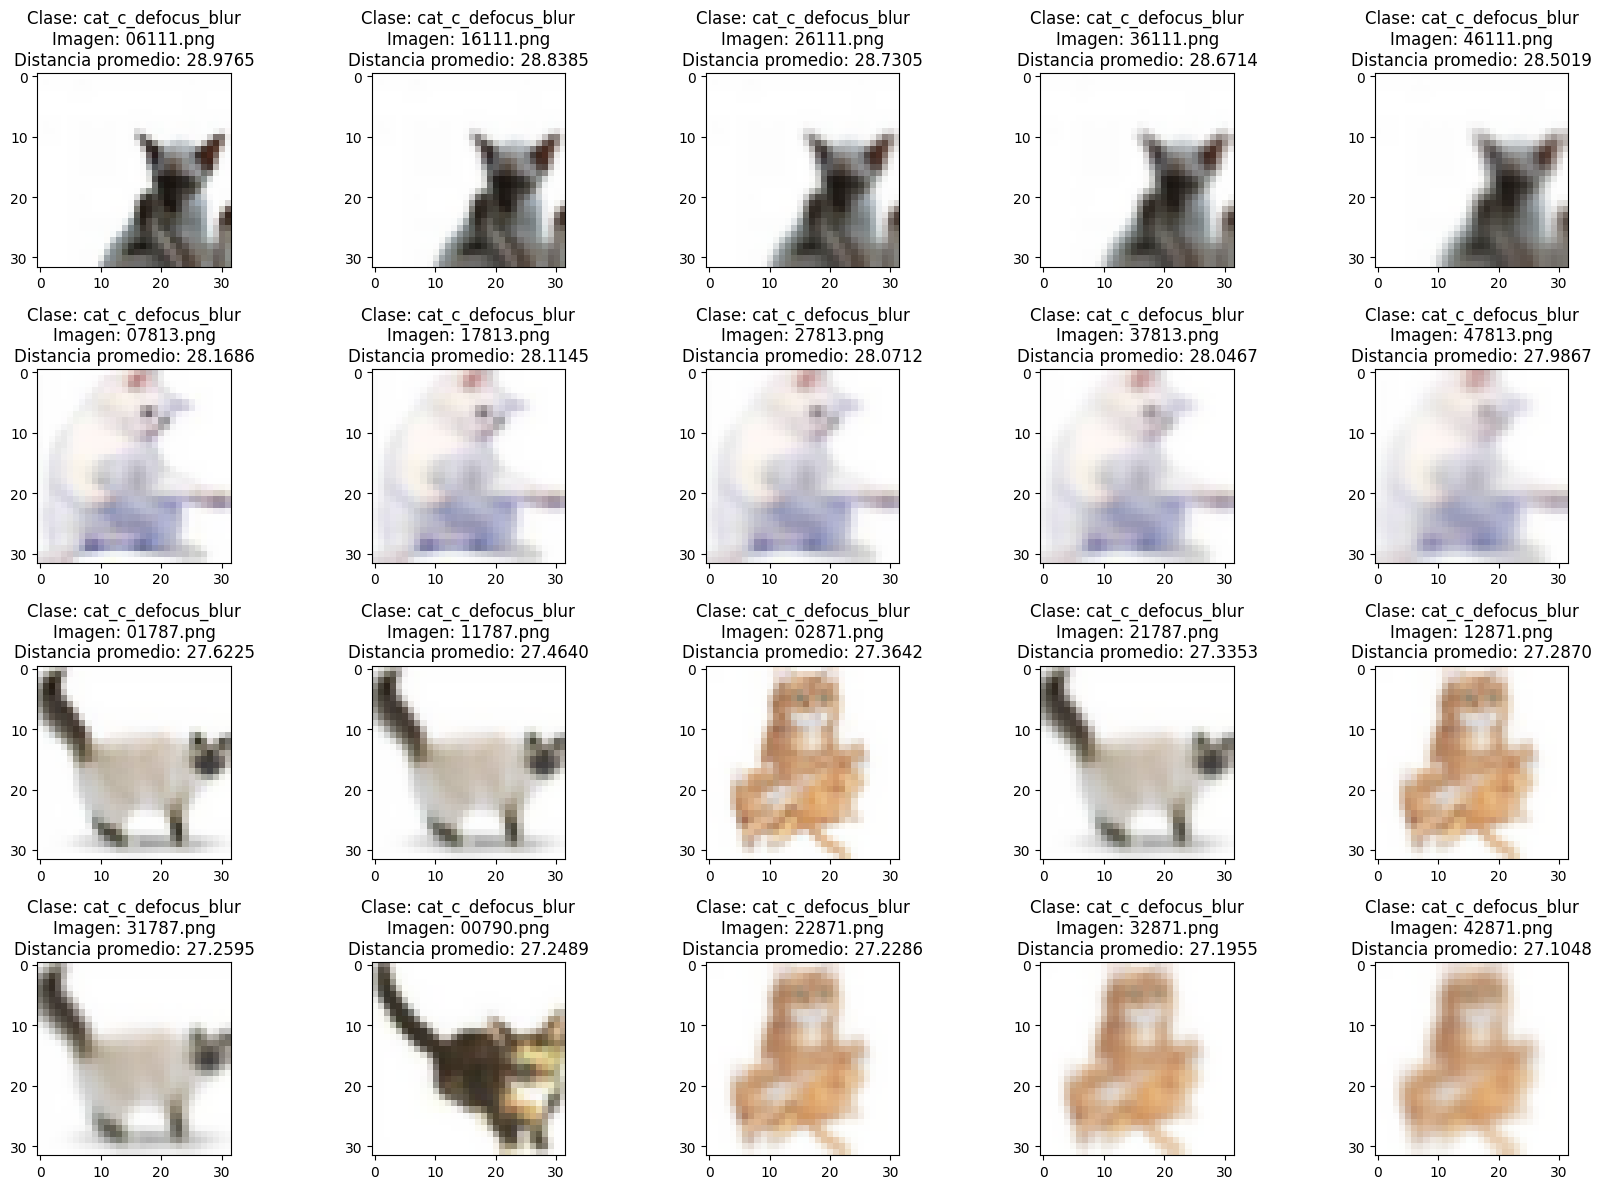

In [18]:
# Visualizar las 10 muestras menos similares
fig, axs = plt.subplots(4, 5, figsize=(17, 12))
for ax, sample, filename, dist in zip(axs.ravel(), muestras_corrupto_to_original, muestras_corrupto_to_original_filenames, avg_dist_corrupto_to_original[distancia_promedio_corrupto_ordenada[:20]]):
    img = sample.reshape(img_height, img_width, 3)
    ax.imshow(img)
    ax.set_title(f'Clase: {class_names[corrupto]}\nImagen: {filename}\nDistancia promedio: {dist:.4f}')
plt.tight_layout()
plt.show()

In [25]:
dist_original_to_corrupto.shape
dist_original_to_corrupto
dist_corrupto_to_original[0,0]

17.168983899886246

In [26]:
# Índices de las muestras que quieres comparar
indice_muestra_original = 0
indice_muestra_corrupta = 0

# Obtener los nombres de las muestras
nombre_muestra_original = filenames[class_original_indices[indice_muestra_original]]
nombre_muestra_corrupta = filenames[class_corrupto_indices[indice_muestra_corrupta]]

# Obtener el valor de la matriz de distancias para estas muestras
distancia = dist_original_to_corrupto[indice_muestra_original, indice_muestra_corrupta]

print(f"La distancia entre la muestra '{nombre_muestra_original}' de la clase original y la muestra '{nombre_muestra_corrupta}' de la clase corrupta es {distancia}")


La distancia entre la muestra 'alley_cat_s_000009.png' de la clase original y la muestra '00000.png' de la clase corrupta es 17.168983899886246


In [24]:
dist_corrupto_to_original

array([[17.1689839 , 13.39640142, 14.60776934, ..., 12.23610323,
        16.2643482 , 15.34718439],
       [18.43552342, 18.86000625, 23.14324232, ..., 15.73326416,
        14.62323032, 19.10859634],
       [18.65614671, 14.19840827, 15.13854806, ..., 15.8242339 ,
        19.3079222 , 16.06118254],
       ...,
       [24.32853754, 18.31347539, 18.88119205, ..., 18.93377417,
        25.19494277, 21.85715423],
       [18.79902121, 13.80571486, 14.6780776 , ..., 16.3427112 ,
        19.49189672, 16.56809975],
       [19.31566832, 13.06838945, 14.77029034, ..., 12.57611207,
        18.61166846, 16.61578123]])

In [20]:
# Calcular la distancia de similitud entre las muestras seleccionadas
similarity_value = np.linalg.norm(least_similar_original_to_corrupto - least_similar_corrupto_to_original)
print(similarity_value)


"""
Aquí se está calculando la norma (o longitud) del vector que va desde least_similar_original_to_corrupto 
hasta least_similar_corrupto_to_original. Esto se hace restando las dos muestras (que da el vector de diferencia) 
y luego calculando la norma de ese vector con np.linalg.norm. En este contexto, la norma del vector de diferencia 
se puede interpretar como una medida de la distancia o disimilitud entre las dos muestras.
La función np.linalg.norm es una función de la biblioteca numpy que calcula la norma de un vector. 
La norma de un vector es una medida de su longitud (en el caso de un vector espacial) o magnitud 
(en el caso de un vector general). En este caso, se está utilizando para calcular la distancia euclidiana 
entre dos puntos en un espacio de alta dimensión (las dos muestras de imágenes).

from scipy.spatial.distance import cdist: cdist es una función de la biblioteca scipy que puede calcular la distancia 
entre cada par de puntos en dos conjuntos de puntos. En este caso, solo estás interesado en la distancia entre dos 
puntos específicos (las dos muestras menos similares), por lo que np.linalg.norm es más apropiado y eficiente. 
Si se quisiera calcular las distancias entre múltiples pares de puntos, entonces cdist sería una mejor opción
"""

28.558979


'\nAquí se está calculando la norma (o longitud) del vector que va desde least_similar_original_to_corrupto \nhasta least_similar_corrupto_to_original. Esto se hace restando las dos muestras (que da el vector de diferencia) \ny luego calculando la norma de ese vector con np.linalg.norm. En este contexto, la norma del vector de diferencia \nse puede interpretar como una medida de la distancia o disimilitud entre las dos muestras.\nLa función np.linalg.norm es una función de la biblioteca numpy que calcula la norma de un vector. \nLa norma de un vector es una medida de su longitud (en el caso de un vector espacial) o magnitud \n(en el caso de un vector general). En este caso, se está utilizando para calcular la distancia euclidiana \nentre dos puntos en un espacio de alta dimensión (las dos muestras de imágenes).\n\nfrom scipy.spatial.distance import cdist: cdist es una función de la biblioteca scipy que puede calcular la distancia \nentre cada par de puntos en dos conjuntos de puntos. E

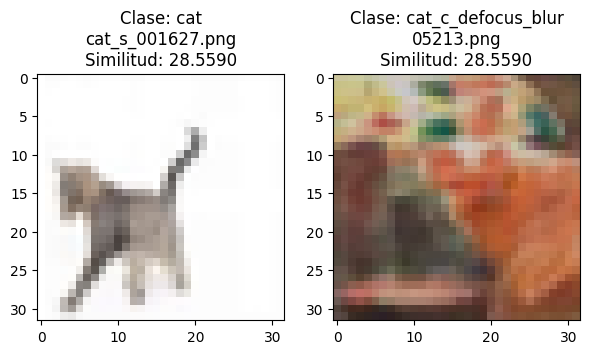

In [17]:
# Visualizar las muestras y la información
least_similar_original_to_corrupto_img = least_similar_original_to_corrupto.reshape(img_height, img_width, 3)
least_similar_corrupto_to_original_img = least_similar_corrupto_to_original.reshape(img_height, img_width, 3)

fig, axs = plt.subplots(1, 2, figsize=(7, 5))
axs[0].imshow(least_similar_original_to_corrupto_img)
axs[0].set_title(f'Clase: {class_names[original]}\n{least_similar_original_to_corrupto_filename}\nSimilitud: {similarity_value:.4f}')
axs[1].imshow(least_similar_corrupto_to_original_img)
axs[1].set_title(f'Clase: {class_names[corrupto]}\n{least_similar_corrupto_to_original_filename}\nSimilitud: {similarity_value:.4f}')
# Entre mayor sea el valor de similitud significa que son menos similares (mas lejanas)
plt.show()